In [1]:
!pip -q install scikit-learn pandas matplotlib



In [2]:
from google.colab import files
uploaded = files.upload()  # pick Students_Week4_Model_Selection.zip from your computer


Saving Students_Week4_Model_Selection.zip to Students_Week4_Model_Selection.zip


In [3]:
!unzip -q "Students_Week4_Model_Selection.zip" -d "lab_week4"
%cd lab_week4/"Students_Week 4_Model Selection"


/content/lab_week4/Students_Week 4_Model Selection


In [27]:
# Cell 2 - make sure data/ contains WA_Fn-UseC_-HR-Employee-Attrition.csv
import os, shutil
from pathlib import Path

os.makedirs("data", exist_ok=True)

# if the zip is already present in working dir, extract it automatically
zip_name = "Students_Week4_Model_Selection.zip"
if Path(zip_name).exists():
    print(f"Found {zip_name} — extracting...")
    !unzip -o "{zip_name}" -d extracted_lab >/dev/null
    # try to copy csv from extracted folder
    possible = list(Path("extracted_lab").rglob("WA_Fn-UseC_-HR-Employee-Attrition.csv"))
    if possible:
        src = str(possible[0])
        shutil.copy(src, "data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
        print("Copied HR CSV to data/ folder.")
else:
    # ask user to upload the CSV (or zip)
    from google.colab import files
    print("Please upload WA_Fn-UseC_-HR-Employee-Attrition.csv (or the ZIP file).")
    uploaded = files.upload()
    for fname in uploaded.keys():
        if fname.lower().endswith(".zip"):
            !unzip -o "{fname}" -d extracted_lab >/dev/null
            possible = list(Path("extracted_lab").rglob("WA_Fn-UseC_-HR-Employee-Attrition.csv"))
            if possible:
                shutil.copy(str(possible[0]), "data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
                print("Extracted CSV from uploaded ZIP and copied to data/")
        elif fname.lower().endswith(".csv"):
            shutil.copy(fname, "data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
            print("Copied uploaded CSV to data/")

print("data folder contents:", os.listdir("data"))


Please upload WA_Fn-UseC_-HR-Employee-Attrition.csv (or the ZIP file).


Saving WA_Fn-UseC_-HR-Employee-Attrition.csv to WA_Fn-UseC_-HR-Employee-Attrition (1).csv
Copied uploaded CSV to data/
data folder contents: ['WA_Fn-UseC_-HR-Employee-Attrition.csv']


In [28]:
# Cell 3 - imports, settings, helper functions
import warnings
warnings.filterwarnings("ignore")   # optional: hides ConvergenceWarning noise; remove if you want to see warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, ParameterGrid, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay
)

np.random.seed(42)
print("Imports complete.")


Imports complete.


In [29]:
# Cell 4 - dataset loader functions
def load_hr_attrition(test_size=0.3, random_state=42):
    """Load IBM HR Attrition (expects data/WA_Fn-UseC_-HR-Employee-Attrition.csv)"""
    path = "data/WA_Fn-UseC_-HR-Employee-Attrition.csv"
    if not Path(path).exists():
        print(f"HR CSV not found at {path}. Please make sure the file is in data/")
        return None, None, None, None, "HR Attrition (Failed)"
    df = pd.read_csv(path)
    # Preprocess
    df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)
    # Drop employee-number-like columns
    df = df.drop(columns=['EmployeeNumber'], errors='ignore')
    X = df.drop(columns=['Attrition'])
    X = pd.get_dummies(X, drop_first=True)  # one-hot encode categoricals
    y = df['Attrition']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)
    print("HR Attrition loaded:", X_train.shape, X_test.shape)
    return X_train, X_test, y_train, y_test, "HR Attrition"

def load_wine_quality(test_size=0.3, random_state=42):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        df = pd.read_csv(url, sep=';')
    except Exception as e:
        print("Could not download Wine Quality:", e)
        return None, None, None, None, "Wine Quality (Failed)"
    df['good_quality'] = (df['quality'] > 5).astype(int)
    X = df.drop(columns=['quality', 'good_quality'])
    y = df['good_quality']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)
    print("Wine Quality loaded:", X_train.shape, X_test.shape)
    return X_train, X_test, y_train, y_test, "Wine Quality"

def load_banknote_authentication(test_size=0.3, random_state=42):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
    try:
        df = pd.read_csv(url, header=None)
    except Exception as e:
        print("Could not download Banknote dataset:", e)
        return None, None, None, None, "Banknote (Failed)"
    # last column is the label
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)
    print("Banknote loaded:", X_train.shape, X_test.shape)
    return X_train, X_test, y_train, y_test, "Banknote Authentication"

def load_qsar_biodegradation(test_size=0.3, random_state=42):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv'
    try:
        df = pd.read_csv(url)
    except Exception as e:
        print("Could not download QSAR Biodegradation:", e)
        return None, None, None, None, "QSAR Biodegradation (Failed)"
    # last column contains 'RB' or 'NRB' — convert to binary
    # If header names vary, try to handle common cases:
    if df.columns[-1] in ['RB', 'NRB', 'class', 'RB?']:
        y = (df.iloc[:, -1] == 'RB').astype(int)
        X = df.iloc[:, :-1]
    else:
        # attempt safe fallback: last column values 'RB' or 'NRB'
        y = (df.iloc[:, -1].astype(str).str.upper() == 'RB').astype(int)
        X = df.iloc[:, :-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)
    print("QSAR Biodegradation loaded:", X_train.shape, X_test.shape)
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

print("Dataset loaders defined.")


Dataset loaders defined.


In [30]:
# Cell 5 - classifiers and parameter grids (pipeline style)
from sklearn.base import clone

# classifier instances (we will place them in a pipeline named 'classifier')
clf_lr = LogisticRegression(solver='liblinear', max_iter=2000, random_state=42)
clf_dt = DecisionTreeClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)
clf_knn = KNeighborsClassifier()

# Parameter grids use pipeline step names: 'feature_selection__k' and 'classifier__<param>'
param_grid_lr = {
    'feature_selection__k': [5, 10, 15],
    'classifier__C': [0.01, 0.1, 1, 10]
}
param_grid_dt = {
    'feature_selection__k': [5, 10, 15],
    'classifier__max_depth': [3, 5, 7, None]
}
param_grid_rf = {
    'feature_selection__k': [5, 10, 15],
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 10, None]
}
param_grid_knn = {
    'feature_selection__k': [5, 10, 15],
    'classifier__n_neighbors': [3, 5, 7]
}

# list of (estimator, param_grid, name)
classifiers_to_tune = [
    (clf_lr, param_grid_lr, "LogisticRegression"),
    (clf_dt, param_grid_dt, "DecisionTree"),
    (clf_rf, param_grid_rf, "RandomForest"),
    (clf_knn, param_grid_knn, "kNN"),
]

print("Classifiers and param grids defined (will be used inside pipeline).")


Classifiers and param grids defined (will be used inside pipeline).


In [32]:
# Cell 6 - manual grid search implementation
def _adjust_grid_for_features(param_grid, n_features):
    """Make sure SelectKBest k values are <= n_features and valid."""
    grid = {}
    for k, vals in param_grid.items():
        if k == 'feature_selection__k':
            vals_adj = [int(v) for v in vals if (isinstance(v, (int, np.integer)) and v <= n_features and v >= 1)]
            # ensure at least 1 value
            if len(vals_adj) == 0:
                vals_adj = [min(10, max(1, n_features))]
            grid[k] = vals_adj
        else:
            grid[k] = vals
    return grid

def run_manual_grid_search(X_train, y_train, dataset_name="Dataset"):
    """Manual grid search: returns dict of name -> fitted pipeline (best found on X_train)."""
    print("\n" + "="*60)
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print("="*60)
    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    for base_clf, param_grid, name in classifiers_to_tune:
        print(f"\n--- Manual search for {name} ---")
        adjusted_grid = _adjust_grid_for_features(param_grid, n_features)
        best_score = -np.inf
        best_params = None

        # iterate all parameter combos
        for params in ParameterGrid(adjusted_grid):
            # build a fresh pipeline (clone classifier to avoid side effects)
            clf = clone(base_clf)
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(f_classif)),
                ('classifier', clf)
            ])
            pipeline.set_params(**params)
            # use roc_auc when possible, fallback to accuracy if something fails
            try:
                scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
            except Exception:
                scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = params.copy()

        # Fit final pipeline with best_params on full training set
        final_clf = clone(base_clf)
        final_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', final_clf)
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)
        best_estimators[name] = final_pipeline

        print(f"Best params for {name}: {best_params}")
        print(f"Best CV score (manual): {best_score:.4f}")

    return best_estimators


In [33]:
# Cell 7 - built-in GridSearchCV implementation
def run_builtin_grid_search(X_train, y_train, dataset_name="Dataset"):
    print("\n" + "="*60)
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print("="*60)
    results_builtin = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    for base_clf, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")
        adjusted_grid = _adjust_grid_for_features(param_grid, n_features)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', clone(base_clf))
        ])

        # GridSearchCV expects the param grid keys to exist; we pass adjusted_grid
        try:
            grid_search = GridSearchCV(pipeline, adjusted_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=0)
            grid_search.fit(X_train, y_train)
            best_est = grid_search.best_estimator_
            best_score = grid_search.best_score_
            best_params = grid_search.best_params_
        except Exception as e:
            # fallback to accuracy scoring in case of errors
            print("GridSearchCV with roc_auc failed, retrying with accuracy. Error:", e)
            grid_search = GridSearchCV(pipeline, adjusted_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
            grid_search.fit(X_train, y_train)
            best_est = grid_search.best_estimator_
            best_score = grid_search.best_score_
            best_params = grid_search.best_params_

        results_builtin[name] = {
            'best_estimator': best_est,
            'best_score (CV)': best_score,
            'best_params': best_params
        }

        print(f"Best params for {name}: {best_params}")
        print(f"Best CV score (GridSearchCV): {best_score:.4f}")

    return results_builtin


In [34]:
# Cell 8 - evaluation function (works with pipelines returned by the search functions)
def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    print("\n" + "="*60)
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print("="*60)

    # Individual model evaluation
    y_pred_probas = {}
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except Exception:
            # if predict_proba not available, attempt decision_function -> scale to [0,1]
            try:
                df = model.decision_function(X_test)
                # min-max scale to 0-1
                y_proba = (df - df.min()) / (df.max() - df.min() + 1e-12)
            except Exception:
                y_proba = np.zeros(len(X_test))

        y_pred_probas[name] = y_proba
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        try:
            auc = roc_auc_score(y_test, y_proba)
        except Exception:
            auc = float('nan')

        print(f"\n{name}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, AUC={auc:.4f}")

    # Voting (soft) - average probabilities across models that produce probabilities
    if len(y_pred_probas) == 0:
        print("No model probabilities available for voting.")
        return None, None

    proba_matrix = np.vstack([y_pred_probas[nm] for nm in y_pred_probas.keys()])
    y_pred_proba_avg = proba_matrix.mean(axis=0)
    y_pred_votes = (y_pred_proba_avg >= 0.5).astype(int)

    # Overall voting metrics
    print("\nVoting classifier (soft) metrics:")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred_votes):.4f}")
    print(f"  Precision: {precision_score(y_test, y_pred_votes, zero_division=0):.4f}")
    print(f"  Recall: {recall_score(y_test, y_pred_votes, zero_division=0):.4f}")
    print(f"  F1: {f1_score(y_test, y_pred_votes, zero_division=0):.4f}")
    try:
        print(f"  AUC: {roc_auc_score(y_test, y_pred_proba_avg):.4f}")
    except Exception:
        print("  AUC: n/a")

    # ROC plot
    plt.figure(figsize=(7, 6))
    for name, proba in y_pred_probas.items():
        try:
            fpr, tpr, _ = roc_curve(y_test, proba)
            plt.plot(fpr, tpr, label=f"{name}")
        except Exception:
            pass
    # Voting
    try:
        fpr_v, tpr_v, _ = roc_curve(y_test, y_pred_proba_avg)
        plt.plot(fpr_v, tpr_v, label=f"Voting (avg)", linewidth=2, linestyle='--')
    except Exception:
        pass
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curves - {dataset_name} ({method_name})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confusion matrix for voting
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Voting Confusion Matrix - {dataset_name} ({method_name})")
    plt.show()

    return y_pred_votes, y_pred_proba_avg


In [35]:
# Cell 9 - orchestrator: run the whole pipeline for a dataset loader
def run_complete_pipeline(dataset_loader):
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {actual_name} (failed to load).")
        return

    print("\n" + "#"*80)
    print(f"PROCESSING DATASET: {actual_name}")
    print("#"*80)

    # Manual grid search and eval
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    _ = evaluate_models(X_test, y_test, manual_estimators, actual_name, method_name="Manual")

    # Built-in grid search and eval
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: info['best_estimator'] for name, info in builtin_results.items()}
    _ = evaluate_models(X_test, y_test, builtin_estimators, actual_name, method_name="Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)


HR Attrition loaded: (1029, 46) (441, 46)

################################################################################
PROCESSING DATASET: HR Attrition
################################################################################

RUNNING MANUAL GRID SEARCH FOR HR ATTRITION

--- Manual search for LogisticRegression ---
Best params for LogisticRegression: {'classifier__C': 0.1, 'feature_selection__k': 15}
Best CV score (manual): 0.7774

--- Manual search for DecisionTree ---
Best params for DecisionTree: {'classifier__max_depth': 3, 'feature_selection__k': 5}
Best CV score (manual): 0.7152

--- Manual search for RandomForest ---
Best params for RandomForest: {'classifier__max_depth': None, 'classifier__n_estimators': 100, 'feature_selection__k': 15}
Best CV score (manual): 0.7765

--- Manual search for kNN ---
Best params for kNN: {'classifier__n_neighbors': 7, 'feature_selection__k': 10}
Best CV score (manual): 0.7002

EVALUATING MANUAL MODELS FOR HR ATTRITION

LogisticRegressi

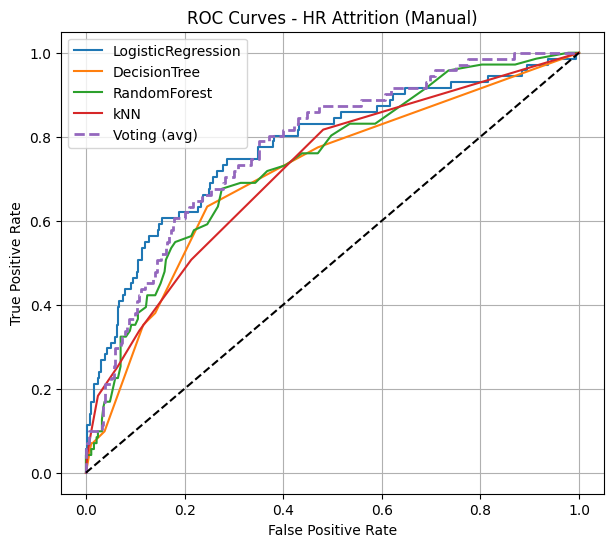

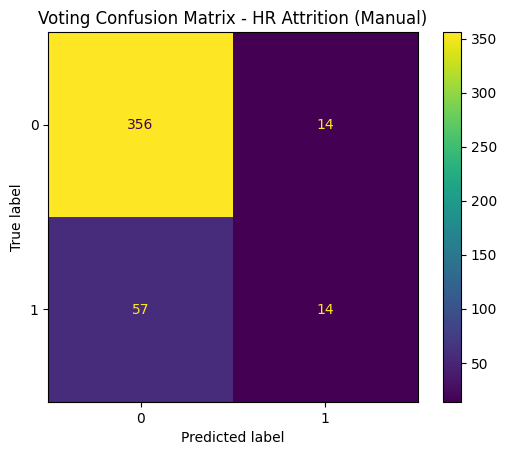


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for LogisticRegression ---
Best params for LogisticRegression: {'classifier__C': 0.1, 'feature_selection__k': 15}
Best CV score (GridSearchCV): 0.7774

--- GridSearchCV for DecisionTree ---
Best params for DecisionTree: {'classifier__max_depth': 3, 'feature_selection__k': 5}
Best CV score (GridSearchCV): 0.7152

--- GridSearchCV for RandomForest ---
Best params for RandomForest: {'classifier__max_depth': None, 'classifier__n_estimators': 100, 'feature_selection__k': 15}
Best CV score (GridSearchCV): 0.7765

--- GridSearchCV for kNN ---
Best params for kNN: {'classifier__n_neighbors': 7, 'feature_selection__k': 10}
Best CV score (GridSearchCV): 0.7002

EVALUATING BUILT-IN MODELS FOR HR ATTRITION

LogisticRegression: Accuracy=0.8571, Precision=0.6333, Recall=0.2676, F1=0.3762, AUC=0.7759

DecisionTree: Accuracy=0.8231, Precision=0.3333, Recall=0.0986, F1=0.1522, AUC=0.7107

RandomForest: Accuracy=0.8322, Precision=0.4286, R

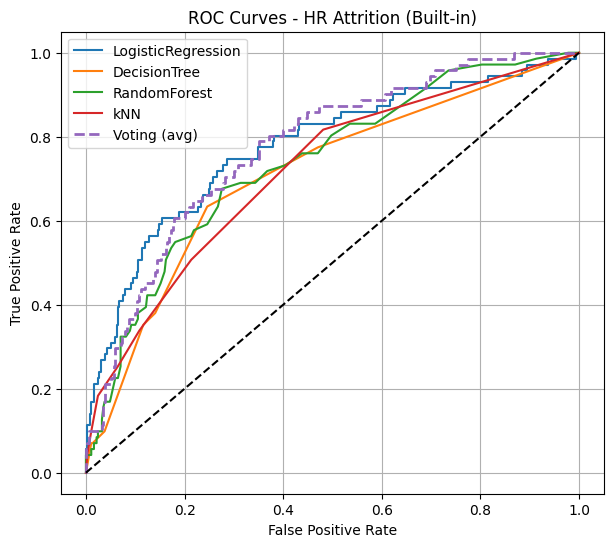

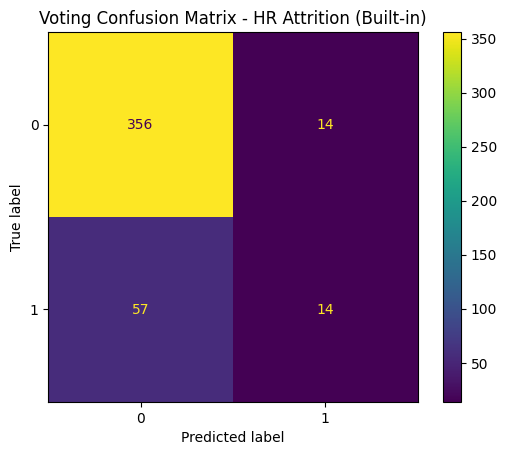


Completed processing for HR Attrition
Wine Quality loaded: (1119, 11) (480, 11)

################################################################################
PROCESSING DATASET: Wine Quality
################################################################################

RUNNING MANUAL GRID SEARCH FOR WINE QUALITY

--- Manual search for LogisticRegression ---
Best params for LogisticRegression: {'classifier__C': 1, 'feature_selection__k': 10}
Best CV score (manual): 0.8049

--- Manual search for DecisionTree ---
Best params for DecisionTree: {'classifier__max_depth': 5, 'feature_selection__k': 5}
Best CV score (manual): 0.7796

--- Manual search for RandomForest ---
Best params for RandomForest: {'classifier__max_depth': None, 'classifier__n_estimators': 100, 'feature_selection__k': 10}
Best CV score (manual): 0.8736

--- Manual search for kNN ---
Best params for kNN: {'classifier__n_neighbors': 7, 'feature_selection__k': 5}
Best CV score (manual): 0.7984

EVALUATING MANUAL MODEL

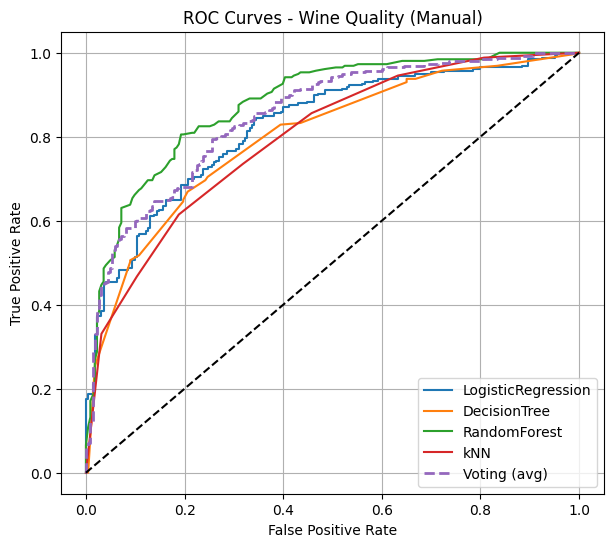

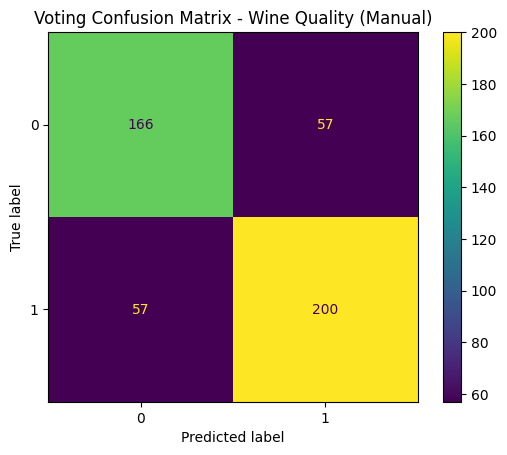


RUNNING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- GridSearchCV for LogisticRegression ---
Best params for LogisticRegression: {'classifier__C': 1, 'feature_selection__k': 10}
Best CV score (GridSearchCV): 0.8049

--- GridSearchCV for DecisionTree ---
Best params for DecisionTree: {'classifier__max_depth': 5, 'feature_selection__k': 5}
Best CV score (GridSearchCV): 0.7796

--- GridSearchCV for RandomForest ---


In [ ]:
# Cell 10 - run the pipeline for the datasets you want
datasets = [
    load_hr_attrition,
    load_wine_quality,
    load_banknote_authentication,
    load_qsar_biodegradation
]

for loader in datasets:
    try:
        run_complete_pipeline(loader)
    except Exception as e:
        print("ERROR while processing:", getattr(loader, "__name__", loader), e)
        # continue to next dataset
